In [1]:
import pandas as pd

data = pd.read_excel(r"fin_data.xlsx")

In [2]:
df1 = data.copy()
df2 = pd.read_excel(r"app_project_list.xlsx")
df2['start'] = pd.to_datetime(df2['start'], format='%Y/%m/%d')
df = pd.merge(df1, df2[['pid', 'start']], on='pid', how='left')
print(df.columns)

Index(['bid', 'pid', 'solverid', 'description', 'DDelivery', 'price',
       'seekerid', 'competition', 'std_award_status', 'std_price', 'word',
       'time_diff', 'userid', 'profile_completeness', 'average_rating',
       'sentiment_score', 'review_count', 'topsis_score', 'cluster',
       'solver_star', 'confidence', 'politeness', 'standardization',
       'experience', 'skill', 'techsupport', 'customization', 'understand',
       'fitness', 'worktime', 'time_diff_dummy', 'start'],
      dtype='object')


In [3]:
# Group by `bid` and `pid`, and calculate the standardized position of `std_price`
df['std_price_standardized'] = df.groupby(['pid'])['std_price'].transform(lambda x: (x - x.min()) / (x.max() - x.min()+1))

df.sample(5)

,bid,pid,solverid,description,DDelivery,price,seekerid,competition,std_award_status,std_price,...,experience,skill,techsupport,customization,understand,fitness,worktime,time_diff_dummy,start,std_price_standardized
41704,255394654,23380440,9480619,"Hello, I read your Job Description; I have Exp...",5,38,27526562,23,0,38.000,...,1,0,0,0,0,0,0,0,2020-01-21,0.025228
7036,257097241,23586195,2736312,Hi there. Your UI/UX design project sounds int...,30,3000,3827596,146,0,3000.000,...,1,1,0,0,0,0,0,0,2020-01-28,0.247423
58638,254914906,23305170,22099154,"Hi,Hope you are doing great.Please review my p...",7,500,32642970,65,0,6.904,...,1,1,0,0,0,0,0,0,2020-01-16,0.000996
21888,256900024,23448133,3193312,"Hi, I'm a talented developer for iOS, Android ...",7,750,9650517,20,0,750.000,...,1,1,0,0,0,0,0,1,2020-01-25,0.098141
33593,255666554,23403102,17977027,"Hello,I am a full stack developer, I have work...",14,410,42729519,48,0,410.000,...,1,0,0,1,1,0,0,1,2020-01-22,0.023920


In [4]:
df['std_price_standardized']

0        0.001379
1        0.001383
2        0.003595
3        0.002482
4        0.299029
           ...   
62124    0.003962
62125    0.004195
62126    0.999920
62127    0.010096
62128    0.620735
Name: std_price_standardized, Length: 62129, dtype: float64

# 相关系数与膨胀系数的可视化
在计算变量相关矩阵和计算VIF以判断多重共线性后，都画合适的图进行可视化展示

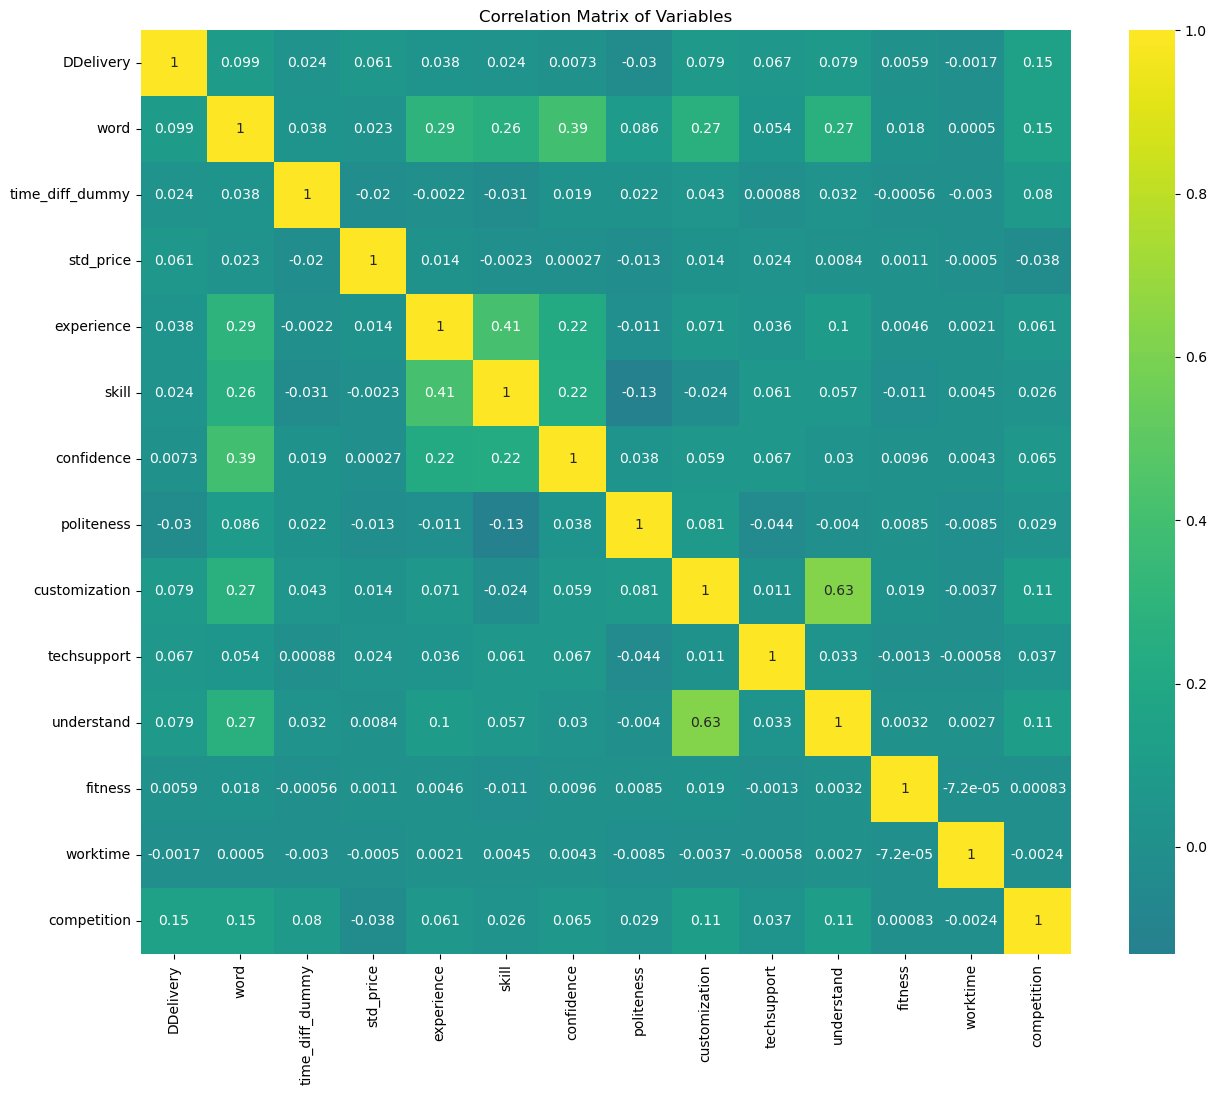

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算自变量的相关性矩阵
correlation_matrix = df[['DDelivery', 'word', 'time_diff_dummy', 'std_price', 'experience', 'skill', 'confidence', 'politeness', 'customization', 'techsupport', 'understand', 'fitness', 'worktime', 'competition']].corr()

# 可视化相关性矩阵
plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.title('Correlation Matrix of Variables')
plt.show()


            Feature       VIF
12         worktime  1.000179
11          fitness  1.001118
3         std_price  1.015200
9       techsupport  1.024747
2   time_diff_dummy  1.277684
0         DDelivery  1.345792
10       understand  2.414608
8     customization  2.489673
7        politeness  2.877562
13      competition  2.915371
5             skill  3.333209
6        confidence  3.335583
1              word  6.375948
4        experience  7.379042


C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\703117605.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=vif_data_sorted, palette="viridis")


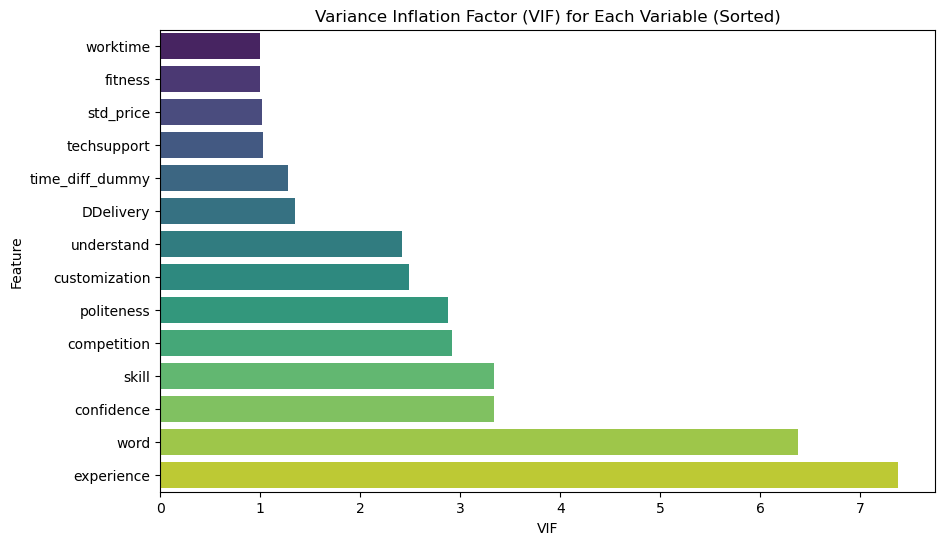

In [7]:

# 定义自变量矩阵
X_vif = df[['DDelivery', 'word', 'time_diff_dummy', 'std_price', 'experience', 'skill', 'confidence', 'politeness', 'customization', 'techsupport', 'understand', 'fitness', 'worktime', 'competition']]

# 计算VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# 按照VIF大小排序
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=True)
# 输出 VIF 数据表
print(vif_data_sorted)
# 可视化VIF值，配色从蓝色渐变到黄色
plt.figure(figsize=(10,6))

# 使用蓝色到黄色的渐变配色
sns.barplot(x="VIF", y="Feature", data=vif_data_sorted, palette="viridis")
plt.title('Variance Inflation Factor (VIF) for Each Variable (Sorted)')
plt.show()

# 使用 linearmodels 库进行逻辑回归

In [9]:
from linearmodels import PanelOLS
import pandas as pd
import statsmodels.api as sm

# Set pid as the index for entity fixed effects
df = df.set_index(['pid','start'])

# Define your independent variables
X = df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price', 'std_price_standardized',
        'experience', 'skill', 'confidence', 'politeness', 'customization', 
        'fitness', 'understand', 'techsupport', 'worktime']]

# Add a constant
X = sm.add_constant(X)

# Define dependent variable
y = df['std_award_status']

# Use solver_star as the other fixed effect
solver_star_effects = df['solver_star']

# Fit the PanelOLS model with both entity (pid) and other (solver_star) fixed effects
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, other_effects=solver_star_effects)
result = model.fit()

# Display the result summary
print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0018
Estimator:                   PanelOLS   R-squared (Between):             -0.0284
No. Observations:               62129   R-squared (Within):               0.0013
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0016
Time:                        16:58:21   Log-likelihood                 6.156e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.5591
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(14,59467)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             7.5591
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\3911901777.py:24: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

competition

  result = model.fit()


In [19]:
from linearmodels import PanelOLS
import pandas as pd
import statsmodels.api as sm



# Define your independent variables
X = df[[ 'competition', 'std_price', 'std_price_standardized',
        'experience', 'skill', 'confidence', 'politeness', 'customization', 
        'fitness', 'understand', 'techsupport', 'worktime']]

# Add a constant
X = sm.add_constant(X)

# Define dependent variable
y = df['std_award_status']

# Use solver_star as the other fixed effect
solver_star_effects = df['solver_star']

# Fit the PanelOLS model with both entity (pid) and other (solver_star) fixed effects
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, other_effects=solver_star_effects)
result = model.fit()

# Display the result summary
print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0018
Estimator:                   PanelOLS   R-squared (Between):             -0.0281
No. Observations:               62129   R-squared (Within):               0.0013
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0017
Time:                        17:00:00   Log-likelihood                 6.156e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9.5689
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(11,59470)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             9.5689
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\4062819680.py:23: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

competition

  result = model.fit()


In [10]:
df['confidence_experience'] = df['confidence'] * df['experience']
df['confidence_skill'] = df['confidence'] * df['skill']
df['confidence_fitness'] = df['confidence'] * df['fitness']
df['confidence_understand'] = df['confidence'] * df['understand']
df['confidence_techsupport'] = df['confidence'] * df['techsupport']
df['confidence_worktime'] = df['confidence'] * df['worktime']
df['confidence_customization'] = df['confidence'] * df['customization']

# 选择自变量
X = df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price_standardized', 'experience', 'skill', 'confidence', 'politeness', 'customization', 'fitness', 'understand', 'techsupport', 'worktime', 'confidence_experience', 'confidence_skill', 'confidence_fitness', 'confidence_understand', 'confidence_techsupport', 'confidence_worktime', 'confidence_customization']]

# 定义因变量
y = df['std_award_status']

# 添加常数
X = sm.add_constant(X)

# 拟合面板数据固定效应逻辑回归模型
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result = model.fit()

# 输出结果
print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0019
Estimator:                   PanelOLS   R-squared (Between):             -0.0286
No. Observations:               62129   R-squared (Within):               0.0013
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0017
Time:                        16:58:22   Log-likelihood                 6.156e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.2609
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(18,59463)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             6.2609
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\226159263.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

confidence_fitness, competition, confidence_worktime

  result = model.fit()


In [21]:
# 选择自变量
X = df[[ 'competition', 'std_price_standardized', 'experience', 'skill', 'confidence', 'politeness', 'customization', 'fitness', 'understand', 'techsupport', 'worktime', 'confidence_experience', 'confidence_skill', 'confidence_fitness', 'confidence_understand', 'confidence_techsupport', 'confidence_worktime', 'confidence_customization']]

# 定义因变量
y = df['std_award_status']

# 添加常数
X = sm.add_constant(X)

# 拟合面板数据固定效应逻辑回归模型
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result = model.fit()

# 输出结果
print(result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0019
Estimator:                   PanelOLS   R-squared (Between):             -0.0283
No. Observations:               62129   R-squared (Within):               0.0013
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0017
Time:                        17:01:30   Log-likelihood                 6.156e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.4790
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(15,59466)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             7.4790
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\3381275434.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

competition, confidence_worktime, confidence_fitness

  result = model.fit()


In [11]:
df['politeness_experience'] = df['politeness'] * df['experience']
df['politeness_skill'] = df['politeness'] * df['skill']
df['politeness_fitness'] = df['politeness'] * df['fitness']
df['politeness_understand'] = df['politeness'] * df['understand']
df['politeness_techsupport'] = df['politeness'] * df['techsupport']
df['politeness_worktime'] = df['politeness'] * df['worktime']
df['politeness_customization'] = df['politeness'] * df['customization']

# 选择自变量
X = df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price_standardized', 'experience', 'skill', 'confidence', 'politeness', 'customization', 'fitness', 'understand', 'techsupport', 'worktime', 'politeness_experience', 'politeness_skill', 'politeness_fitness', 'politeness_understand', 'politeness_techsupport', 'politeness_worktime', 'politeness_customization']]

# 定义因变量
y = df['std_award_status']

# 添加常数
X = sm.add_constant(X)

# 拟合面板数据固定效应逻辑回归模型
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result = model.fit()

# 输出结果
print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0019
Estimator:                   PanelOLS   R-squared (Between):             -0.0287
No. Observations:               62129   R-squared (Within):               0.0014
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0017
Time:                        16:58:23   Log-likelihood                 6.156e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.2177
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(18,59463)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             6.2177
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\2152808699.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

politeness_fitness, competition, politeness_worktime

  result = model.fit()


In [12]:
# 选择自变量
X = df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price_standardized', 
        'confidence', 'politeness',
        'experience', 'skill','techsupport',
        'customization', 'fitness', 'understand',  'worktime', 
        'confidence_experience', 'confidence_skill','confidence_techsupport',  'confidence_fitness', 'confidence_understand', 'confidence_worktime', 'confidence_customization', 
        'politeness_experience', 'politeness_skill', 'politeness_techsupport','politeness_fitness', 'politeness_understand', 'politeness_worktime', 'politeness_customization']]

# 定义因变量
y = df['std_award_status']

# 添加常数
X = sm.add_constant(X)

# 拟合面板数据固定效应逻辑回归模型
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result = model.fit()

# 输出结果
print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0020
Estimator:                   PanelOLS   R-squared (Between):             -0.0289
No. Observations:               62129   R-squared (Within):               0.0014
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0017
Time:                        16:58:24   Log-likelihood                 6.157e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.2209
Entities:                        2646   P-value                           0.0000
Avg Obs:                       23.480   Distribution:                F(23,59458)
Min Obs:                       1.0000                                           
Max Obs:                       196.00   F-statistic (robust):             5.2209
                            

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\682826789.py:17: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

competition, confidence_fitness, confidence_worktime, politeness_fitness, politeness_worktime

  result = model.fit()


In [13]:
# Scaled price: std_price / competition (normalizing by competition level)
df['scaled_price'] = df['std_price'] / (df['competition'] + 1)  # adding 1 to avoid division by zero
# 选择自变量
X = df[['DDelivery', 'word', 'time_diff_dummy',
        'competition', 'std_price_standardized',
        'skill', 'confidence', 'politeness',  'understand', 
        'confidence_skill',  'confidence_understand',  
        'politeness_skill',  'politeness_understand']]

# 定义因变量
y = df['std_award_status']
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# 显示 VIF
print(vif_data)
# 添加常数
X = sm.add_constant(X)

# 拟合面板数据固定效应逻辑回归模型
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result = model.fit()

# 输出结果
print(result.summary)


                  Variable       VIF
0                DDelivery  1.365534
1                     word  6.077399
2          time_diff_dummy  1.280770
3              competition  2.959539
4   std_price_standardized  1.549880
5                    skill  8.239985
6               confidence  7.386913
7               politeness  6.346322
8               understand  6.698259
9         confidence_skill  7.849818
10   confidence_understand  4.035882
11        politeness_skill  6.350371
12   politeness_understand  4.423266
                          PanelOLS Estimation Summary                           
Dep. Variable:       std_award_status   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0287
No. Observations:               62129   R-squared (Within):               0.0005
Date:                Thu, Sep 26 2024   R-squared (Overall):              0.0008
Time:                        16:58:25   Log-likelihood                 6.154e

C:\Users\ergo_user\AppData\Local\Temp\ipykernel_19384\178654580.py:23: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

competition

  result = model.fit()


In [14]:
## 分开高竞争和低竞争

In [15]:
df_full = df.copy()
# Recalculate high and low competition based on the 75th percentile of the 'competition' variable
value_75_percentile = df_full['competition'].quantile(0.75)

# Reassign high and low competition groups based on the 75th percentile
df_full['competition_group_new'] = df_full['competition'].apply(lambda x: 'high_competition' if x > value_75_percentile else 'low_competition')

# Display the distribution of the new competition group classification
df_full['competition_group_new'].value_counts()


competition_group_new
low_competition     46643
high_competition    15486
Name: count, dtype: int64

In [16]:
# Filter data for the new high-competition and low-competition settings
high_competition_new_df = df_full[df_full['competition_group_new'] == 'high_competition']
low_competition_new_df = df_full[df_full['competition_group_new'] == 'low_competition']

# Define the independent variables focusing on customization and control variables for both groups
X_high_customization = high_competition_new_df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price_standardized', 
        'confidence', 'politeness',
        'experience', 'skill','techsupport',
        'customization',  'understand',  'worktime', 
        'confidence_experience', 'confidence_skill','confidence_techsupport',   'confidence_understand', 'confidence_worktime', 'confidence_customization', 
        'politeness_experience', 'politeness_skill', 'politeness_techsupport', 'politeness_understand', 'politeness_worktime', 'politeness_customization']]
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_high_customization.columns
vif_data['VIF'] = [variance_inflation_factor(X_high_customization.values, i) for i in range(X_high_customization.shape[1])]
# 显示 VIF
print(vif_data)

X_low_customization = low_competition_new_df[['DDelivery', 'word', 'time_diff_dummy', 'competition', 'std_price_standardized', 
        'confidence', 'politeness',
        'experience', 'skill','techsupport',
        'customization', 'understand',  'worktime', 
        'confidence_experience', 'confidence_skill','confidence_techsupport',   'confidence_understand', 'confidence_worktime', 'confidence_customization', 
        'politeness_experience', 'politeness_skill', 'politeness_techsupport', 'politeness_understand', 'politeness_worktime', 'politeness_customization']]
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_low_customization.columns
vif_data['VIF'] = [variance_inflation_factor(X_low_customization.values, i) for i in range(X_low_customization.shape[1])]
# 显示 VIF
print(vif_data)
# Define the dependent variable
y_high_customization = high_competition_new_df['std_award_status']
y_low_customization = low_competition_new_df['std_award_status']

# Add a constant to the models
X_high_customization = sm.add_constant(X_high_customization)
X_low_customization = sm.add_constant(X_low_customization)

# 拟合面板数据固定效应逻辑回归模型



# Fit logistic regression models for high and low competition data
model_high_customization = PanelOLS(y_high_customization, X_high_customization, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result_high_customization = model_high_customization.fit()

model_low_customization = PanelOLS(y_low_customization, X_low_customization, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result_low_customization = model_low_customization.fit()

# Display the summaries of both models
high_competition_summary = result_high_customization.summary
low_competition_summary = result_low_customization.summary

high_competition_summary, low_competition_summary


C:\Users\ergo_user\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                    Variable        VIF
0                  DDelivery   1.240430
1                       word   7.289860
2            time_diff_dummy   1.358030
3                competition  11.032896
4     std_price_standardized   1.739737
5                 confidence  31.318692
6                 politeness  22.912646
7                 experience  33.068424
8                      skill  18.680985
9                techsupport  48.284569
10             customization  13.843553
11                understand  12.703169
12                  worktime        NaN
13     confidence_experience  36.236812
14          confidence_skill  11.051193
15    confidence_techsupport  47.658200
16     confidence_understand   7.896142
17       confidence_worktime        NaN
18  confidence_customization   8.182930
19     politeness_experience  34.509065
20          politeness_skill  11.594201
21    politeness_techsupport   1.964521
22     politeness_understand   8.372708
23       politeness_worktime        NaN


C:\Users\ergo_user\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\ergo_user\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                    Variable        VIF
0                  DDelivery   1.825499
1                       word   6.344504
2            time_diff_dummy   1.272896
3                competition   4.638584
4     std_price_standardized   1.623645
5                 confidence  21.776519
6                 politeness  13.764202
7                 experience  23.193171
8                      skill  16.889450
9                techsupport  16.976246
10             customization  11.461652
11                understand   9.454849
12                  worktime        inf
13     confidence_experience  26.977264
14          confidence_skill   9.724484
15    confidence_techsupport  16.056127
16     confidence_understand   6.449041
17       confidence_worktime        inf
18  confidence_customization   6.857078
19     politeness_experience  24.348391
20          politeness_skill  10.833778
21    politeness_techsupport   2.037781
22     politeness_understand   7.037208
23       politeness_worktime        NaN


ValueError: other_effects must have the same number of entities and time periods as dependent.

In [ ]:
# Filter data for the new high-competition and low-competition settings
high_competition_new_df = df_full[df_full['competition_group_new'] == 'high_competition']
low_competition_new_df = df_full[df_full['competition_group_new'] == 'low_competition']

# Define the independent variables focusing on customization and control variables for both groups
X_high_customization = high_competition_new_df[['competition', 'std_price_standardized', 
        'confidence', 'politeness',
        'experience', 'skill','techsupport',
        'customization',  'understand',  'worktime', 
        'confidence_experience', 'confidence_skill','confidence_techsupport',   'confidence_understand', 'confidence_worktime', 'confidence_customization', 
        'politeness_experience', 'politeness_skill', 'politeness_techsupport', 'politeness_understand', 'politeness_worktime', 'politeness_customization']]
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_high_customization.columns
vif_data['VIF'] = [variance_inflation_factor(X_high_customization.values, i) for i in range(X_high_customization.shape[1])]
# 显示 VIF
print(vif_data)

X_low_customization = low_competition_new_df[[ 'competition', 'std_price_standardized', 
        'confidence', 'politeness',
        'experience', 'skill','techsupport',
        'customization', 'understand',  'worktime', 
        'confidence_experience', 'confidence_skill','confidence_techsupport',   'confidence_understand', 'confidence_worktime', 'confidence_customization', 
        'politeness_experience', 'politeness_skill', 'politeness_techsupport', 'politeness_understand', 'politeness_worktime', 'politeness_customization']]
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_low_customization.columns
vif_data['VIF'] = [variance_inflation_factor(X_low_customization.values, i) for i in range(X_low_customization.shape[1])]
# 显示 VIF
print(vif_data)
# Define the dependent variable
y_high_customization = high_competition_new_df['std_award_status']
y_low_customization = low_competition_new_df['std_award_status']

# Add a constant to the models
X_high_customization = sm.add_constant(X_high_customization)
X_low_customization = sm.add_constant(X_low_customization)

# 拟合面板数据固定效应逻辑回归模型



# Fit logistic regression models for high and low competition data
model_high_customization = PanelOLS(y_high_customization, X_high_customization, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result_high_customization = model_high_customization.fit()

model_low_customization = PanelOLS(y_low_customization, X_low_customization, entity_effects=True, drop_absorbed=True, check_rank=False,other_effects=solver_star_effects)
result_low_customization = model_low_customization.fit()

# Display the summaries of both models
high_competition_summary = result_high_customization.summary
low_competition_summary = result_low_customization.summary

high_competition_summary, low_competition_summary
